# Artificial Immune System algorithm implementation

The **Artificial Immune System (AIS)** is an optimization algorithm that mimics
the adaptive immune response in biological systems. AIS efficiently handles
complex tasks like **scheduling** due to its learning and adaptive capabilities. In this project, AIS will be responsible for **distributing families** across available days, maintaining the daily visitor limit (between 125 and 300), while minimizing penalty costs.

Here is the implementation:

---

Firstly, we need to load the input data and define some constants which are the **boundaries** for our scheduling task:

In [1]:
import csv

with open('data/family_data.csv', mode='r', newline='', encoding='utf-8') as file:
    reader = csv.reader(file)
    headers = next(reader)
    family_data = [list(map(int, line)) for line in reader]

In [2]:
# Some constant values
num_families = 5000
num_days = 100
min_occupancy = 125
max_occupancy = 300

## Algorithm functions

Then let's observe the functions of **AIS algorithm**, step by step:

## `is_valid` function:

### **Description**
The `is_valid` function checks whether a given solution satisfies the occupancy constraints for the workshop tours. Specifically, it ensures that the number of visitors per day is between the minimum (`min_occupancy`) and maximum (`max_occupancy`) allowed values.

### **Parameters**
- `solution`: A list where each element represents the day assigned to a family.  
  - Example: `[5, 10, 15, ...]` means family 1 is assigned to day 5, family 2 to day 10, etc.

### **Returns**
- `True` if the solution is valid (i.e., all days have between `min_occupancy` and `max_occupancy` visitors).
- `False` if the solution violates the constraints.

### **Steps**
1. **Initialize Daily Occupancy**:
   - Create a list `daily_occupancy` of size `num_days` (100) to track the number of visitors per day.

2. **Calculate Occupancy**:
   - For each family in the solution:
     - Retrieve the assigned day and the number of people in the family.
     - Update the `daily_occupancy` list to reflect the number of visitors for that day.

3. **Check Constraints**:
   - Use a list comprehension to check if all days have between `min_occupancy` (125) and `max_occupancy` (300) visitors.
   - Return `True` if all days satisfy the constraints; otherwise, return `False`.

In [5]:
def is_valid(solution):
    daily_occupancy = [0] * num_days
    for family_id, day in enumerate(solution):
        daily_occupancy[day - 1] += family_data[family_id][-1]

    return all(min_occupancy <= occupancy <= max_occupancy for occupancy in daily_occupancy)

## `initialize_population` function:

### **Description**
The `initialize_population` function generates an initial population of valid solutions for the workshop scheduling problem. Each solution is a list of days assigned to families, ensuring that the number of visitors per day is between `min_occupancy` (125) and `max_occupancy` (300).

To handle the complexity of the problem and ensure valid solutions, the function uses a **greedy algorithm** to prioritize families with more people and assigns them to days first. This approach helps satisfy the constraints more efficiently.

### **Parameters**
- `population_size`: The number of solutions to generate for the initial population.

### **Returns**
- A list of valid solutions (each solution is a list of assigned days for all families).

---

## **Key steps**

### **1. Sorting families by size**
- Families are sorted in **descending order** by the number of people (`n_people`). This ensures that larger families are assigned first, reducing the likelihood of violating the `max_occupancy` constraint.

### **2. Assigning days to families**
- For each family, the function tries to assign a day from their preferred choices (`choices`).
- If no preferred day is available (i.e., assigning the family to that day would exceed `max_occupancy`), the function selects any valid day.

### **3. Ensuring minimum occupancy**
- After assigning all families, the function checks if all days have at least `min_occupancy` visitors.
- If not, it attempts to **redistribute families** from overpopulated days to underpopulated days while maintaining the constraints.


In [6]:
import random

def initialize_population(population_size):
    population = []
    for _ in range(population_size):
        solution = []
        daily_occupancy = [0] * num_days

        sorted_families = sorted(family_data, key=lambda x: x[-1], reverse=True)

        for family in sorted_families:
            choices = family[1:-1]
            n_people = family[-1]

            valid_choices = [day for day in choices if daily_occupancy[day - 1] + n_people <= max_occupancy]

            if valid_choices:
                assigned_day = random.choice(valid_choices)
            else:
                valid_values = [day for day in range(1, num_days + 1) if daily_occupancy[day - 1] + n_people <= max_occupancy]
                assigned_day = random.choice(valid_values)

            solution.append(assigned_day)
            daily_occupancy[assigned_day - 1] += n_people

        if all(occupancy >= min_occupancy for occupancy in daily_occupancy):
            population.append(solution)
        else:
            for day in range(num_days):
                if daily_occupancy[day] < min_occupancy:
                    for family_id, assigned_day in enumerate(solution):
                        family = family_data[family_id]
                        n_people = family[-1]

                        if (daily_occupancy[day] + n_people <= max_occupancy and
                            daily_occupancy[assigned_day - 1] - n_people >= min_occupancy):
                            solution[family_id] = day + 1
                            daily_occupancy[assigned_day - 1] -= n_people
                            daily_occupancy[day] += n_people
                            break

        population.append(solution)

    return population

## `evaluate_solution` function:

### **Description**
The `evaluate_solution` function calculates the total cost of a given solution. The total cost is the sum of two components:
1. **Preference cost**: The cost of consolation gifts for families based on how far their assigned day is from their preferred choices.
2. **Accounting penalty**: Additional costs incurred due to daily occupancy fluctuations, as defined by Santa's accounting department.

### **Parameters**
- `solution`: A list where each element represents the day assigned to a family.

### **Formula**

**Total cost** = **Preference cost** + **Accounting penalty**



## Helper function: `calculate_preference_cost`

### **Description**
The `calculate_preference_cost` function computes the cost of consolation gifts for all families based on their assigned days. The cost depends on how far the assigned day is from their preferred choices.

### **Parameters**
- `solution`: A list where each element represents the day assigned to a family.

### **Steps**
1. For each family:
   - Determine which choice (if any) corresponds to the assigned day.
   - Calculate the cost of gifts based on the choice index and the number of people in the family.
2. Sum the costs for all families.

### **Cost table**
| Choice Index | Cost Formula                          |
|--------------|---------------------------------------|
| 0            | \$0                                   |
| 1            | \$50                                  |
| 2            | \$50 + \$9 × `n_people`               |
| 3            | \$100 + \$9 × `n_people`              |
| 4            | \$200 + \$9 × `n_people`              |
| 5            | \$200 + \$18 × `n_people`             |
| 6            | \$300 + \$18 × `n_people`             |
| 7            | \$300 + \$36 × `n_people`             |
| 8            | \$400 + \$36 × `n_people`             |
| 9            | \$500 + \$235 × `n_people`            |
| Otherwise    | \$500 + \$434 × `n_people`            |



## Helper function: `calculate_accounting_penalty`

### **Description**
The `calculate_accounting_penalty` function computes the additional costs incurred due to daily occupancy fluctuations. These costs are based on an empirical formula provided by Santa's accounting department.

### **Formula**
The accounting penalty is calculated using the following formula:

![Accounting Penalty Formula](../data/formula.png)
  
  where:
  - N_d: Number of people on day d.
  - N_{d+1}: Number of people on the next day.

### **Steps**
1. Calculate the daily occupancy for each day.
2. Apply the formula to compute the penalty for each day.
3. Sum the penalties for all days.

In [7]:
def calculate_preference_cost(solution):
    total_cost = 0
    for family_id, assigned_day in enumerate(solution):
        family = family_data[family_id]
        choices = family[1:-1]
        n_people = family[-1]

        # Determining which choice corresponds to the assigned day
        choice_index = choices.index(assigned_day) if assigned_day in choices else len(choices)

        # Calculating the cost of gifts
        if choice_index == 0:
            cost = 0
        elif choice_index == 1:
            cost = 50
        elif choice_index == 2:
            cost = 50 + 9 * n_people
        elif choice_index == 3:
            cost = 100 + 9 * n_people
        elif choice_index == 4:
            cost = 200 + 9 * n_people
        elif choice_index == 5:
            cost = 200 + 18 * n_people
        elif choice_index == 6:
            cost = 300 + 18 * n_people
        elif choice_index == 7:
            cost = 300 + 36 * n_people
        elif choice_index == 8:
            cost = 400 + 36 * n_people
        elif choice_index == 9:
            cost = 500 + 235 * n_people
        else:
            cost = 500 + 434 * n_people

        total_cost += cost

    return total_cost

def calculate_accounting_penalty(solution):
    daily_occupancy = [0] * num_days
    for family_id, assigned_day in enumerate(solution):
        n_people = family_data[family_id][-1]
        daily_occupancy[assigned_day - 1] += n_people

    penalty = 0
    for d in range(num_days):
        Nd = daily_occupancy[d]
        Nd_next = daily_occupancy[d + 1] if d < num_days - 1 else Nd
        penalty += ((Nd - 125) / 400) * Nd**(0.5 + abs(Nd - Nd_next) / 50)
    return penalty

def calculate_affinity(solution):
    return calculate_preference_cost(solution) + calculate_accounting_penalty(solution)

## `mutate` function:
The `mutate` function performs a mutation on the current solution by changing the assigned days for a randomly selected subset of families. If the mutation results in a solution that violates constraints, the function attempts to repair it using a local search.

### **Parameters**
- `solution`: The current solution (a list of days assigned to each family).
- `max_attempts`: The maximum number of attempts to find a valid mutation (default: 100).

### **Steps**
1. **Select Families to Mutate**:
   - Randomly select a small number of families (e.g., 1–5% of all families) to mutate.
2. **Apply Mutation**:
   - For each selected family, assign a new day randomly chosen from their preferences.
3. **Check Validity**:
   - If the new solution is valid (satisfies all constraints), return it.
4. **Local Search**:
   - If the new solution is invalid, use the `local_search` function to repair it.
5. **Return Solution**:
   - If a valid solution is found within `max_attempts`, return it. Otherwise, return the original solution.

### **Example**
```python
new_solution = mutate(current_solution)

In [8]:
def mutate(solution, max_attempts=100):
    for _ in range(max_attempts):
        num_mutations = max(1, int(len(family_data) * 0.05))
        families_to_mutate = random.sample(range(len(family_data)), num_mutations)

        new_solution = solution.copy()

        for family_id in families_to_mutate:
            family = family_data[family_id]
            choices = family[1:-1]

            new_day = random.choice(choices)
            new_solution[family_id] = new_day

        if is_valid(new_solution):
            return new_solution

        new_solution = local_search(new_solution)
        if is_valid(new_solution):
            return new_solution

    return solution

## `local_search` function:
The `local_search` function attempts to repair an invalid solution by moving families between days to satisfy the constraints (minimum 125 and maximum 300 people per day).

### **Parameters**
- `solution`: The current solution (a list of days assigned to each family).

### **Steps**
1. **Calculate daily occupancy**:
   - Compute the number of people assigned to each day.
2. **Fix underpopulated days**:
   - For days with fewer than 125 people, try to move families from overpopulated days.
3. **Fix overpopulated days**:
   - For days with more than 300 people, try to move families to underpopulated days.
4. **Return repaired solution**:
   - Return the solution after attempting to fix all violations.

In [9]:
def local_search(solution):
    daily_occupancy = [0] * num_days
    for family_id, day in enumerate(solution):
        daily_occupancy[day - 1] += family_data[family_id][-1]

    for day in range(100):
        while daily_occupancy[day] < min_occupancy or daily_occupancy[day] > max_occupancy:
            if daily_occupancy[day] < min_occupancy:
                # Finding families that can be moved on this day
                for family_id, assigned_day in enumerate(solution):
                    family = family_data[family_id]
                    n_people = family[-1]

                    # We check whether it is possible to move the family on this day
                    if (daily_occupancy[day] + n_people <= max_occupancy and
                        daily_occupancy[assigned_day - 1] - n_people >= min_occupancy):
                        # Moving the family
                        solution[family_id] = day + 1
                        daily_occupancy[assigned_day - 1] -= n_people
                        daily_occupancy[day] += n_people
                        break
                else:
                    break

            elif daily_occupancy[day] > max_occupancy:
                for family_id, assigned_day in enumerate(solution):
                    if assigned_day == day + 1:
                        family = family_data[family_id]
                        n_people = family[-1]

                        valid_days = [d for d in range(1, num_days + 1) if daily_occupancy[d - 1] + n_people <= max_occupancy]
                        if valid_days:
                            new_day = random.choice(valid_days)
                            solution[family_id] = new_day
                            daily_occupancy[day] -= n_people
                            daily_occupancy[new_day - 1] += n_people
                            break
                else:
                    break

    return solution

## `select_population` function:

### **Description**
The `select_population` function performs **selection** in the artificial immune system (AIS) algorithm. It combines the current population and the new population (generated through mutation or other operations), evaluates their fitness, and selects the best solutions to form the next generation.

### **Parameters**
- `population`: The current population of solutions.
- `new_population`: The new population of solutions generated through mutation or other operations.

### **Returns**
- A new population containing the best solutions from the combined population.

---

### **Steps**

### **1. Combine populations**
- The current population and the new population are combined into a single list called `combined_population`.

### **2. Evaluate solutions**
- The fitness of each solution in the combined population is evaluated using the `evaluate_solution` function. This function calculates the total cost of a solution, which includes:
  - **Preference Cost**: The cost of consolation gifts for families based on their assigned days.
  - **Accounting Penalty**: Additional costs due to daily occupancy fluctuations.

### **3. Sort solutions**
- The combined population is sorted by their fitness scores in ascending order (lower cost is better).

### **4. Select best solutions**
- The top `len(population)` solutions are selected to form the next generation. This ensures that the population size remains constant.

In [10]:
def select_population(population, new_population, samples_to_save=[]):
    combined_population = population + new_population
    combined_scores = [calculate_affinity(sol) for sol in combined_population]

    sorted_population = [sol for _, sol in sorted(zip(combined_scores, combined_population), key=lambda x: x[0])]

    selected_population = sorted_population[:(len(population) - len(samples_to_save))] + samples_to_save
    return selected_population

## Simulated Annealing

Simulated Annealing is a probabilistic optimization algorithm inspired by the annealing process in metallurgy. It is used to find a global optimum in a large search space by exploring both good and bad solutions, with the probability of accepting worse solutions decreasing over time.

### **Why Add SA to AIS?**
- **AIS Limitation**: The Artificial Immune System (AIS) algorithm is good at exploring the search space but may get stuck in local optima.
- **SA Strength**: SA can escape local optima by accepting worse solutions with a decreasing probability, allowing it to explore more of the search space.
- **Hybrid Benefit**: By combining AIS with SA, we leverage the exploration capabilities of AIS and the exploitation capabilities of SA, leading to better solutions.

### **How SA Works**
1. **Initialization**: Start with an initial solution and set an initial temperature.
2. **Neighbor Generation**: Generate a neighboring solution by making small changes (e.g., mutation).
3. **Acceptance Criteria**:
   - If the neighbor solution is better, accept it.
   - If the neighbor solution is worse, accept it with a probability based on the temperature and the cost difference.
4. **Cooling Schedule**: Gradually reduce the temperature to decrease the probability of accepting worse solutions.
5. **Termination**: Stop after a fixed number of iterations or when the temperature reaches a minimum value.

### **Key Parameters**
- **Initial Temperature**: Controls the initial probability of accepting worse solutions.
- **Cooling Rate**: Determines how quickly the temperature decreases.
- **Maximum Iterations**: The number of iterations SA runs to refine the solution.

### **Integration with AIS**
- After each iteration of AIS, the best solution is refined using SA.
- This hybrid approach ensures that the best solutions found by AIS are further improved, leading to lower total costs.

### **Expected Outcome**
- The hybrid AIS-SA algorithm should produce **better solutions** (lower total cost) compared to using AIS alone.
- The algorithm will be more **robust** and less likely to get stuck in local optima.

In [11]:
import random
import math

def simulated_annealing(solution, initial_temp, cooling_rate, max_iter):
    current_solution = solution.copy()
    current_cost = calculate_affinity(current_solution)
    best_solution = current_solution.copy()
    best_cost = current_cost

    temperature = initial_temp

    for iteration in range(max_iter):
        # Generate a neighbor solution by mutating the current solution
        neighbor_solution = mutate(current_solution)
        neighbor_cost = calculate_affinity(neighbor_solution)

        # Calculate the cost difference
        cost_diff = neighbor_cost - current_cost

        # Accept the neighbor solution if it's better or with a certain probability
        if cost_diff < 0 or random.random() < math.exp(-cost_diff / temperature):
            current_solution = neighbor_solution
            current_cost = neighbor_cost

            # Update the best solution if needed
            if current_cost < best_cost:
                best_solution = current_solution
                best_cost = current_cost

        # Cool down the temperature
        temperature *= cooling_rate

    return best_solution

### Artificial Immune System Algorithm

This cell implements an **Artificial Immune System (AIS)** algorithm, which is inspired by the biological immune system. The algorithm evolves a population of solutions over a number of iterations to find the best solution.

#### Key Steps:
1. **Initialization**:
   - A population of solutions is initialized using `initialize_population(pop_size)`.

2. **Iteration Loop**:
   - **Affinity Calculation**: The fitness (affinity) of each solution is calculated using `calculate_affinity(sol)`.
   - **Best Solution Selection**: The solution with the lowest cost (best affinity) is identified.
   - **Cost History**: The cost of the best solution is recorded in `cost_history`.
   - **Refinement**: The best solution is refined using **Simulated Annealing** to potentially improve it.
   - **Mutation**: A new population is generated by mutating the best solution.
   - **Selection**: The next generation is selected from the current and new populations.

3. **Output**:
   - The algorithm returns the best solution found after `max_iter` iterations.

#### Parameters:
- `pop_size`: Size of the population.
- `max_iter`: Maximum number of iterations.

#### Helper Functions:
- `initialize_population(pop_size)`: Initializes the population.
- `calculate_affinity(sol)`: Calculates the fitness of a solution.
- `simulated_annealing(solution, initial_temp, cooling_rate, max_iter)`: Refines a solution using simulated annealing.
- `mutate(solution)`: Mutates a solution to generate new candidates.
- `select_population(old_pop, new_pop)`: Selects the next generation from the old and new populations.

In [14]:
def artificial_immune_system(pop_size, max_iter):
    # Initialize population with correct format
    valid_population = False

    while not valid_population:
        population = initialize_population(pop_size)
        if min([calculate_affinity(sol) for sol in population]) > 0:
            valid_population = True

    # List to store the cost history
    cost_history = []

    for iteration in range(max_iter):
        # Evaluate the population
        affinities = [calculate_affinity(sol) for sol in population]

        # Find the best solution in the current population
        best_solution = population[affinities.index(min(affinities))]
        best_cost = min(affinities)

        # Record the cost of the best solution
        cost_history.append(best_cost)

        if iteration % 5 == 0:
            # Print progress
            print(f"Iteration {iteration}, Best Score: {best_cost}")

        # Refine the best solution using Simulated Annealing
        refined_solution = simulated_annealing(
            best_solution,
            initial_temp=1000,  # Initial temperature
            cooling_rate=0.95,  # Cooling rate
            max_iter=100        # Maximum iterations for SA
        )
        refined_cost = calculate_affinity(refined_solution)

        # Replace the best solution with the refined solution if it's better
        if refined_cost < best_cost:
            best_solution = refined_solution
            best_cost = refined_cost

        # Generate new population through mutation
        new_population = [mutate(best_solution.copy()) for _ in range(pop_size)]

        # Select the next generation
        population = select_population(population, new_population)

    return best_solution

In [23]:
solution = artificial_immune_system(300, 100)
print("Best solution:", calculate_affinity(solution))

Iteration 0, Best Score: 3111699453.697228
Iteration 5, Best Score: 8876406.976835787
Iteration 10, Best Score: 6493845.565454026
Iteration 15, Best Score: 6493845.565454026
Iteration 20, Best Score: 5835298.963393349
Iteration 25, Best Score: 5450043.5169769935
Iteration 30, Best Score: 5063241.599826975
Iteration 35, Best Score: 4998722.443279306
Iteration 40, Best Score: 4823663.747940268
Iteration 45, Best Score: 4242592.138423221
Iteration 50, Best Score: 4170952.6412161724
Iteration 55, Best Score: 4031784.649988708
Iteration 60, Best Score: 3982853.328359351
Iteration 65, Best Score: 3982853.328359351
Iteration 70, Best Score: 3931093.8789212164
Iteration 75, Best Score: 3931093.8789212164
Iteration 80, Best Score: 3908395.910696808
Iteration 85, Best Score: 3908395.910696808
Iteration 90, Best Score: 3871232.870176079
Iteration 95, Best Score: 3871232.870176079
Best solution: 3871232.870176079


In [24]:
import pandas as pd

family_ids = [id for id in range(0, num_families)]

# Create DataFrame
data = {'family_id': family_ids, 'assigned_day': solution}
df = pd.DataFrame(data)

# Writing data to CSV
df.to_csv('solution.csv', index=False)

## Possible improvements:

We will try to improve the efficiency of the optimization process using various 'smart' techniques and additional methods:


### `smart_mutation` function:

The smart_mutation function performs mutations on a given solution, prioritizing days that are close to the family's initial preferences. This approach improves convergence by favoring solutions that align better with family preferences while maintaining valid occupancy constraints. However, it may reduce solution diversity over time.

#### **Parameters:**
solution: A list where each element represents the day assigned to a family.

mutation_rate: The probability of mutating the assigned day for each family (default is 0.05 or 5%).

#### **Returns:**

A new mutated solution (list of assigned days for all families).

#### **Advantages:**
Faster Convergence: By favoring mutations to days near the family's existing preference, it speeds up the convergence to local optima. It exploits existing good structures in the solution.

Constraint Adherence: It checks max_occupancy constraints when assigning a new day. This reduces the probability of generating invalid solutions.

#### **Disadvantages:**
Reduced Diversity: The preference for nearby days can cause the algorithm to get stuck in local optima, particularly if the initial solution is far from the global optimum.

Dependence on Initial Solution: If the starting solution is poor, the limited mutation window may lead to slow improvement.

In [16]:
def smart_mutation(solution, mutation_rate=0.05):

    new_solution = solution.copy()
    daily_occupancy = [0] * num_days
    for family_id, day in enumerate(new_solution):
        daily_occupancy[day - 1] += family_data[family_id][-1]

    for family_id in range(len(new_solution)):
        if random.random() < mutation_rate:
            family = family_data[family_id]
            current_day = new_solution[family_id]
            choices = family[1:-1]
            n_people = family[-1]

            nearby_days = [d for d in range(max(1, current_day - 3), min(num_days, current_day + 3))]
            valid_days = [d for d in nearby_days if daily_occupancy[d - 1] + n_people <= max_occupancy]

            if valid_days:
                new_day = random.choice(valid_days)
                new_solution[family_id] = new_day
                daily_occupancy[current_day - 1] -= n_people
                daily_occupancy[new_day - 1] += n_people

    if is_valid(new_solution):
            return new_solution

    new_solution = local_search(new_solution)
    if is_valid(new_solution):
        return new_solution

### `elitism_selection` function:
Preserve the Best Solutions: The core goal is to minimize a cost function (evaluate_solution or calculate_affinity). elitism_selection ensures that the best solutions found so far are directly carried over to the next generation without being subjected to mutation or crossover. This is a safety net to prevent accidental regression. The algorithm attempts to schedule families to different dates to minimize preference and accounting costs. In the evaluate_solution function it is important that the most accurate values are passed to the next iteration and not changed randomly.

Accelerate Convergence: By guaranteeing that the best solutions survive, elitism helps the algorithm converge faster. It focuses the search in promising regions of the solution space.

#### **Advantages:**
Guaranteed Improvement (Monotonic Improvement): Each generation is guaranteed to be at least as good as the previous generation's best, and possibly better. Since the best solutions in a generation always survive to the next, the overall performance of the algorithm tends to improve steadily. It avoids cases where an iteration worsens the initial solution.

Faster Convergence: It reduces the search space by guaranteeing that the most promising solutions are always considered, leading to better solutions more quickly.


#### **Disadvantages:**
Premature Convergence: Strong selection pressure towards elite solutions reduces diversity, hindering exploration of potentially better solutions.

Stuck in Local Optima: Dominance by a few elite solutions can cause the algorithm to converge to suboptimal results if the initial elite solutions are not globally optimal. The algorithm loses the ability to explore other ranges of options.

In [18]:
def elitism_selection(population, fitness_scores, num_elites=5):
    """
    Saves the best solutions (elite solutions)
    """
    sorted_indices = sorted(range(len(fitness_scores)), key=lambda i: fitness_scores[i])
    elites = [population[i] for i in sorted_indices[:num_elites]]

    return elites

### `antibody_competition` function:
The antibody_competition function, in the context of this scheduling problem, would implement a selective pressure on the algorithm: this would eliminate candidate solutions based on cost.
A selection process simulates the "survival of the fittest"

Simulate competition between antibodies for resources (survival).
For each antibody, randomly sample k other antibodies and compare affinities.
The antibody with the lowest affinity (highest cost) is removed.
This is a more aggressive selection approach than just sorting.

Args:
    population: A list of solutions.
    fitness_scores: A list of fitness scores corresponding to each solution.
    k: The number of competitors to sample for each antibody.

Returns:
        A new population with the weaker antibodies removed.

In [19]:
import random

def antibody_competition(population, fitness_scores, k=5):
    new_population = population[:]  # Create a copy to avoid modifying the original
    to_remove = []

    for i in range(len(population)):
        competitors = random.sample(range(len(population)), k)  # Select k random competitors
        competitors.append(i)  # Add the current antibody to the competition

        worst_index = competitors[0]
        for index in competitors:
            if fitness_scores[index] > fitness_scores[worst_index]:  # Higher score is worse
                worst_index = index

        if worst_index == i:  # If the current antibody is the worst
            to_remove.append(i)

    # Remove the antibodies in reverse order to avoid index issues
    to_remove.sort(reverse=True)
    for index in to_remove:
        if index < len(new_population): # Check if the index is still valid
            del new_population[index]

    return new_population



---

### **Summation:**

Now let's use these new functions to observe how it can help us reach **better results** in optimisation in terms of this scheduling problem:  

In [25]:
def artificial_immune_system_updated(pop_size, max_iter):

    # Initialize population with correct format
    valid_population = False

    while not valid_population:
        population = initialize_population(pop_size)
        if min([calculate_affinity(sol) for sol in population]) > 0:
            valid_population = True

    # List to store the cost history
    cost_history = []

    for iteration in range(max_iter):
        # Evaluate the population
        affinities = [calculate_affinity(sol) for sol in population]

        # Competition phase
        population = antibody_competition(population, affinities, k=5)

        # Find the best solution in the current population
        best_solution = population[affinities.index(min(affinities))]
        best_cost = min(affinities)

        # Record the cost of the best solution
        cost_history.append(best_cost)

        while len(population) < pop_size:
            population.append(smart_mutation(best_solution.copy()))

        if iteration % 5 == 0:
            # Print progress
            print(f"Iteration {iteration}, Best Score: {best_cost}")

        # Refine the best solution using Simulated Annealing
        refined_solution = simulated_annealing(
            best_solution,
            initial_temp=1000,  # Initial temperature
            cooling_rate=0.95,  # Cooling rate
            max_iter=100        # Maximum iterations for SA
        )
        refined_cost = calculate_affinity(refined_solution)

        # Replace the best solution with the refined solution if it's better
        if refined_cost < best_cost:
            best_solution = refined_solution
            best_cost = refined_cost

        # Generate new population through mutation
        new_population = [smart_mutation(best_solution.copy()) for _ in range(pop_size)]

        # Find elite solutions to save
        elite_solutions = elitism_selection(population, affinities, num_elites = int(pop_size * 0.05) ) # 5% of the best solutions in population will be elite

        # Select the next generation (with elite solutions saved)
        population = select_population(population, new_population, elite_solutions)

    return best_solution

In [27]:
solution_new = artificial_immune_system_updated(100, 100)
print("Best solution:", calculate_affinity(solution_new))

Iteration 0, Best Score: 3467334776.0898137
Iteration 5, Best Score: 7598694.7782966485
Iteration 10, Best Score: 6703511.604210322
Iteration 15, Best Score: 6107569.270682612
Iteration 20, Best Score: 5572057.504987125
Iteration 25, Best Score: 5163646.2409392
Iteration 30, Best Score: 5163646.2409392
Iteration 35, Best Score: 5144238.60691812
Iteration 40, Best Score: 5021382.483508813
Iteration 45, Best Score: 5021382.483508813
Iteration 50, Best Score: 5009578.531708243
Iteration 55, Best Score: 5009578.531708243
Iteration 60, Best Score: 5009578.531708243
Iteration 65, Best Score: 5009578.531708243
Iteration 70, Best Score: 4880735.35475973
Iteration 75, Best Score: 4846625.279988932
Iteration 80, Best Score: 4812495.491103159
Iteration 85, Best Score: 4812495.491103159
Iteration 90, Best Score: 4812495.491103159
Iteration 95, Best Score: 4812495.491103159
Best solution: 4810830.459992483


As we can see, these modifications doesn't affect significantly on the result.



---


## Using different numbers of parameters


Let's see how tuning the parameters of our AIS algorithm can affect on performance of the function:

### 1. Size of population

We will use different **numbers of population size** and observe how it can affect:

In [ ]:
!pip install plotly

Size: 50, Avg: 4993408.82 ± 781328.41
Size: 100, Avg: 4512926.43 ± 303963.08
Size: 150, Avg: 4724739.40 ± 610281.98
Size: 200, Avg: 4381936.42 ± 322335.74
Size: 250, Avg: 4253866.38 ± 262725.28
Size: 300, Avg: 4293871.32 ± 506067.34
Size: 350, Avg: 4324877.28 ± 302458.12
Size: 400, Avg: 4702270.08 ± 527485.77


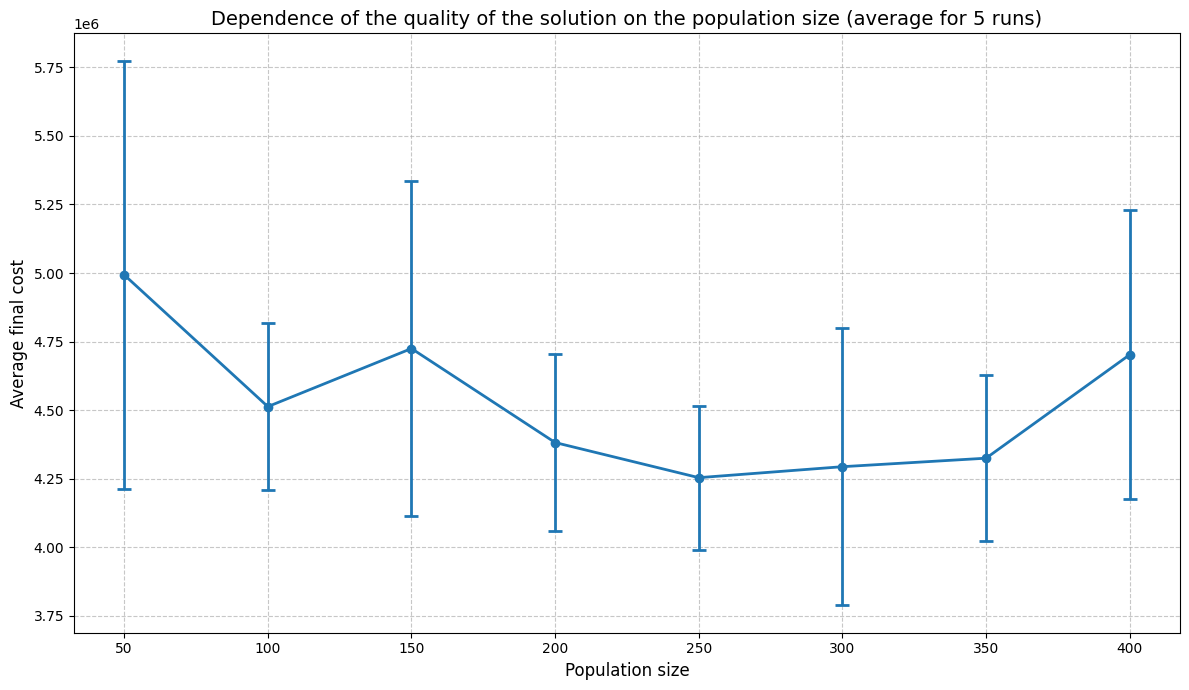

In [19]:
import numpy as np
import matplotlib.pyplot as plt

population_size = [50, 100, 150, 200, 250, 300, 350, 400]

num_runs = 5  # Number of runs for each population size
average_results = []
std_deviation = []

for size in population_size:
    run_results = []
    for _ in range(num_runs):
        run_results.append(calculate_affinity(artificial_immune_system(size, 100)))

    average_results.append(np.mean(run_results))
    std_deviation.append(np.std(run_results))
    print(f"Size: {size}, Avg: {average_results[-1]:.2f} ± {std_deviation[-1]:.2f}")

# Graph with confidence intervals
plt.figure(figsize=(12, 7))
plt.errorbar(population_size, average_results, yerr=std_deviation,
             fmt='o-', capsize=5, capthick=2, linewidth=2)
plt.title('Dependence of the quality of the solution on the population size (average for 5 runs)', fontsize=14)
plt.xlabel('Population size', fontsize=12)
plt.ylabel('Average final cost', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(population_size)
plt.tight_layout()
plt.show()

As we can see, size of 250 is the most suitable in this algorithm, striking a balance
between diversity and computational efficiency.

- But we need to note that for a population size of 300, the larger standard deviation shows us that, with this size value, we can achieve better results overall (not average results) - for instance, we got the best solution using a size of 300.

---


## Comparsion with other optimization algorithms

To assess the relative performance of our AIS-based approach, we compared it with two other well-known metaheuristic algorithms: **Artificial Bee Colony (ABC)** and **Genetic Algorithm (GA)**. Each algorithm was tested under comparable conditions.

| Chosen Algorithm |   Best Cost   |
|------------------|---------------|
|    AIS (ours)    | 3,871,232.87  |
|    GA            | 4,900,340.53  |
|    ABC           | 6,146,535.72  |

### Observations:

- AIS is well-suited for **constraint-heavy** optimization tasks like the Santa scheduling problem.
- All three algorithms are capable of producing valid solutions and adapting to the problem structure.
- AIS **outperformed** both ABC and GA, with the latter being closer in performance.
- With more fine-tuning, GA and ABC could potentially yield **better results**. However, AIS remains the most **flexible and effective** method under the current framework.
